In [15]:
# im2col
# 채널 수 : 1, 배치 사이즈 : 1
# 패딩하지않고 스트라이드 : 1 인경우
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def im2col(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape # 입력이미지의 높이, 넓이
    
    cols = np.zeros((flt_h * flt_w, out_h * out_w)) # 생성되는 행렬 크기
    
    for h in range(out_h):
        h_lim = h + flt_h
        for w in range(out_w):
            w_lim = w + flt_w
            cols[:, h * out_w + w] = image[h : h_lim, w : w_lim].reshape(-1)
            
    return cols

In [3]:
img = np.array([[1,2,3,4],
               [5,6,7,8],
               [9,10,11,12],
               [13,14,15,16]])
cols = im2col(img, 2, 2, 3, 3)
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


In [4]:
# im2col 속도 개선 : for문을 필터기준으로 돌림
def im2col(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape
    cols = np.zeros((flt_h, flt_w, out_h, out_w))
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[h, w, :, :] = image[h : h_lim, w : w_lim]
            
    cols = cols.reshape(flt_h * flt_w, out_h * out_w)
    
    return cols

In [5]:
# 배치, 채널 고려
def im2col(images, flt_h, flt_w, out_h, out_w):
    # 배치사이즈, 채널수, 입력이미지높이, 너비
    n_bt, n_ch, img_h, img_w = images.shape
    
    col = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[:, :, h, w, :, :] = images[:, :, h:h_lim, w:wlim]
            
    cols = cols.transpose(1,2,3,0,4,5).reshape(
            n_ch * flt_h * flt_w, n_bt * out_h * out_w)
    return cols

In [6]:
# 패딩, 스트라이드 고려
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad,pad), (pad,pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride * out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
            
    cols = cols.transpose(1,2,3,0,4,5).reshape(n_ch * flt_h * flt_w, n_bt*out_h*out_w)
    
    return cols

In [7]:
img = np.array([[[[1,2,3,4],
               [5,6,7,8],
               [9,10,11,12],
               [13,14,15,16]]]])
cols = im2col(img, 2, 2, 3, 3, 1, 0)
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


In [8]:
# col2im 구현
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3,0,1,2,4,5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride * out_h
        for w in range(flt_w):
            w_lim = w + stride * out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
            
    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [9]:
cols = np.ones((4,4))
img_shape = (1,1,3,3)
images = col2im(cols, img_shape, 2, 2, 2, 2, 1, 0)
print(images)

[[[[1. 2. 1.]
   [2. 4. 2.]
   [1. 2. 1.]]]]


In [29]:
# CNN 구현
class ConvLayer:
    
    # x_ch: 입력 채널 수, x_h: 입력 이미지 높이, x_W: 입력 이미지 너비
    # n_flt: 필터 수, flt_h: 필터 높이, flt_w: 필터 너비
    # stride: 스트라이드 너비, pad: 패딩 너비
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):
        
        # 파라미터, 외부에서 접근할 필요없는 파라미터
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # 필터와 편향 초깃값
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 출력이미지, 외부에서 접근 가능하도록 self로 만듦
        # 출력 채널수, 높이, 너비
        self.y_ch = n_flt
        self.y_h = (x_h - flt_h + 2*pad) // stride +1
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1
        
        # 아다드래드 AdaGrad
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력 이미지와 필터를 행렬로 변환
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch * flt_h * flt_w)
        
        # 출력 계산: 행렬 곱, 편향 더하기, 활성화 함수
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0,3,1,2)
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # 필터와 편향 기울기
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 입력 기울기
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [30]:
class PoolingLayer:
    # n_bt: 배치 사이즈, y_ch: 출력 채널 수, y_h: 출력 높이, y_w: 출력 너비
    # x_ch: 입력 채널 수, x_h: 입력 이미지 높이, x_w: 입력 이미지 너비
    # pool: 풀링 영역 크기, pad: 패딩 너비
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        self.y_ch = x_ch # 춮력 채널 수
        self.y_h = x_h//pool if x_h%pool == 0 else x_h//pool + 1 # 출력 높이
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool + 1 # 출력 너비
        
    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력 이미지를 행렬로 변환
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 출력 계산: 맥스 풀링
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0,3,1,2)
        
        # 최대값 인덱스 저장
        self.max_index = np.argmax(cols, axis=1)
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 출력 기울기 축 변경
        grad_y = grad_y.transpose(0,2,3,1)
        
        # 행렬 생성
        grad_cols = np.zeros((pool*pool, grad_y.size))
        # 각 열의 최댓값이 있던 위치에 출력 기울기 입력
        grad_cols[self.max_index.reshape(-1),
                 np.arange(grad_y.size)] = grad_y.reshape(-1)
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4)
        grad_cols = grad_cols.reshape(y_ch * pool*pool, n_bt*y_h*y_w)
        
        #입력 기울기
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [23]:
#전결합층 부모class
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [24]:
# 전결합 은닉층
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [25]:
# 전결합 출력층
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u) / np.sum(np.exp(u), axis=1).reshape(-1,1)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [17]:
# 손글씨 데이터
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

# 표준화
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

# 정답을 원핫 인코딩으로 표현
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
#훈련 데이터와 테스트 데이터
index = np.arange(n_data)
index_train = index[index % 3 != 0]
index_test = index[index % 3 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_test, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0] # 훈련 데이터 샘플 수
n_test = input_test.shape[0]



In [18]:
img_h = 8
img_w = 8  # 이미지 너비
img_ch = 1

wb_width = 0.1 # 가중치 설정을 위한 정규분포 표준편차
eta = 0.01 # 학습률
epoch = 50
batch_size = 8
interval = 10 #경과 표시 간격
n_sample = 200 # 오차 계산 샘플 수

(1797, 64)


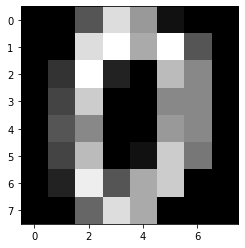

In [20]:
digits = datasets.load_digits()
print(digits.data.shape) # 64개 픽셀이 직선상에 1797개 저장

plt.imshow(digits.data[0].reshape(8,8), cmap = "gray")
plt.show()

In [21]:
print(digits.target.shape)
print(digits.target[:50])

(1797,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]


In [32]:
# 각층의 초기화
cl_1 = ConvLayer(img_ch, img_h, img_w, 10,3,3,1,1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 100)
ol_1 = OutputLayer(100,10)

# 순전파
def forward_propagation(x):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)
    
# 역전파
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)
    
# 가중치, 편향 수정
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)
    
# 교차 엔트로피 오차 계산
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size

# 샘플을 순전파
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand)
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

In [33]:
# 오차 기록용
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# 학습 경과 기록
n_batch = n_train // batch_size
for i in range(epoch):
    # 오차 측정
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample)
    error_test = get_error(t, n_sample)
    
    # 오차 기록
    train_error_x.append(i)
    train_error_y.append(error_train)
    test_error_x.append(i)
    test_error_y.append(error_test)
    
    # 경과 표시
    if i%interval == 0:
        print("Epoch:"+str(i)+"/"+str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:"+str(error_test))
        
    # 학습
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)
    for j in range(n_batch):
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        forward_propagation(x)
        backpropagation(t)
        uppdate_wb()

Epoch:0/50 Error_train:2.338823968231765 Error_test:2.3236608779443304
Epoch:10/50 Error_train:0.0678537958579115 Error_test:0.03890926298509542
Epoch:20/50 Error_train:0.02252510091657328 Error_test:0.04018066959221786
Epoch:30/50 Error_train:0.01814674508121371 Error_test:0.02762481959180525
Epoch:40/50 Error_train:0.01610494429023887 Error_test:0.011162770900505983


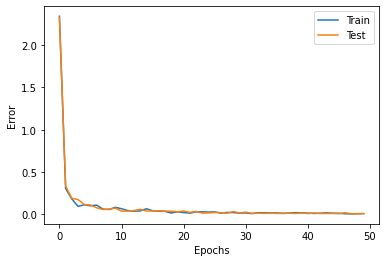

Accuracy Train: 100.0% Accuracy Test: 100.0%


In [36]:
# 오차기록그래프
plt.plot(train_error_x, train_error_y, label = "Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# 정답률 측정
x, t = forward_sample(input_train, correct_train, n_train)
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))
x, t = forward_sample(input_test, correct_test, n_test)
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
     "Accuracy Test:", str(count_test/n_test*100) + "%")

In [37]:
# 이미지 분류
samples = input_test[:5] # 테스트 데이터 5개
forward_propagation(samples)
print(ol_1.y)
print(correct_test[:5])

[[1.08336510e-09 9.99247067e-01 3.13962574e-06 5.32397546e-06
  4.43073691e-05 1.28901866e-08 2.49877904e-07 6.38652631e-06
  6.93492189e-04 1.92160203e-08]
 [1.44032402e-06 3.88839436e-04 9.81676937e-01 2.89963074e-07
  3.74253083e-05 2.78713199e-11 1.28789814e-06 2.29567264e-05
  1.78707583e-02 6.52376388e-08]
 [7.70759158e-07 1.17378922e-04 8.02444452e-09 1.46278393e-09
  9.99790995e-01 7.99659954e-10 6.26423917e-05 2.31031624e-05
  5.09946305e-06 7.28288261e-11]
 [1.53379822e-05 1.67717952e-03 1.68588121e-06 6.05059058e-02
  7.99101747e-07 4.70585020e-01 6.36530839e-09 8.67491875e-06
  2.01895049e-04 4.67003495e-01]
 [9.55072668e-10 8.91941336e-06 3.45873283e-08 2.85089086e-05
  6.45839540e-06 4.02823288e-07 1.38708176e-13 9.99949092e-01
  2.20011311e-06 4.38266380e-06]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
